# 09-02. 순환 신경망으로 IMDB 리뷰 분류하기

## IMDB 리뷰 데이터셋 살펴보기

### 토큰(token)
- 주로 영어 문장에서 공백 단위로 분리한 단어   
문장을 소문자화하고 특수문자를 제거하는 과정을 거침
- 토큰은 의미를 가지지 않는 특정한 숫자로 매핑되어 있음
- 특정 정수는 특정한 용도로 예약되어 있음
  - 0: 패딩
  - 1: 문장의 시작
  - 2: 어휘사전에 없는 토큰

### 어휘 사전
- 훈련세트에서 고유한 단어를 뽑아 만든 목록

## IMDB 리뷰 데이터셋
- imdb.com에서 수집한 리뷰를 긍정과 부정으로 분류한 데이터셋
- 훈련 데이터와 테스트 데이터가 각각 25,000개씩 총 50,000개의 샘플
- 텐서플로에서는 이미 정수로 바꾼 데이터가 포함되어 있음

In [ ]:
# imdb 모듈을 가져와 자주 등장하는 단어 500개를 적재

from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)  # num_words=500으로 지정해 자주 사용하는 단어 500개만 등록
print(train_input.shape, test_input.shape)  # 각 세트의 크기 확인

17464789/17464789 [==============================] - 0s 0us/step
(25000,) (25000,)


In [ ]:
# 첫 번째와 두 번째 리뷰 길이 출력
print(len(train_input[0]), len(train_input[1]))

218 189


- IMDB 리뷰 텍스트는 샘플들의 길이가 상이하기 때문에 1차원 배열의 형태로 구성되며 리뷰마다 별도의 파이썬 리스트로 구성되어 있음

In [ ]:
# 첫 번째 리뷰에 담긴 내용 출력
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


- 이미 정수로 변환되어 있음
- 어휘 사전에는 500개의 단어만 들어있기 때문에 사전에 없는 단어는 2로 표시

In [ ]:
# 타깃 데이터 출력
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


- 리뷰가 긍정인지(1) 부정인지(0) 판단하는 이진 분류 문제

In [ ]:
# 훈련 세트에서 검증 세트 추출

from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
# 각 리뷰의 길이 계산

import numpy as np

lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


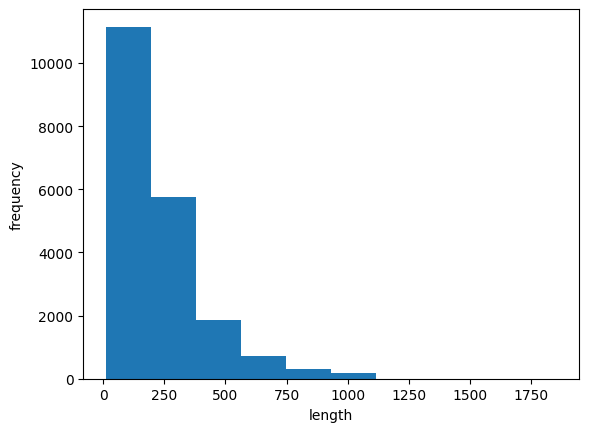

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

- 대부분의 리뷰는 300 미만이지만 매우 긴 데이터가 존재하기 때문에 평균이 중간값보다 높음

In [ ]:
# 모델 훈련을 위해 100개의 단어만 사용하도록 처리

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)  # 단어가 100개 이하인 리뷰를 패딩하는 함수
print(train_seq.shape)

(20000, 100)


In [ ]:
# 처리된 첫 번째 샘플 출력
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [ ]:
# 원래 첫 번째 샘플의 길이와 뒷 부분 출력
print(len(train_input[0]), train_input[0][-10:])

259 [6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


- 첫 번째 샘플의 앞 부분이 잘렸음을 확인할 수 있음
- 일반적으로 시퀀스 뒷 부분의 정보가 더 유용할 것으로기대되기 때문에 pad_sequences()는 기본적으로 앞 부분을 잘라냄
  - 뒷 부분을 잘라내고 싶다면 truncating 매개변수를 'post'로 변경

In [ ]:
# 처리된 여섯 번째 샘플을 출력
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 길이가 100 미만인 샘플의 경우 역시 비교적 덜 유용하다고 기대되어지는 앞 부분에 패딩이 들어감
- padding 매개변수를 'post'로 바꾸어 앞 부분에 패딩을 추가할 수 있음

In [ ]:
# 검증 세트도 동일하게 처리
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

In [ ]:
# Sequential 클래스를 사용해 신경망 생성

from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))  # 원-핫 인코딩을 적용하기 위해 2번째 차원을 500(어휘 사전에 포함된 단어 수)으로
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# 케라스 유틸리티를 사용해 train_seq를 원-핫 인코딩으로 변환

train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [ ]:
# train_oh의 첫 번째 토큰(10) 확인
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


- 첫 번째 토큰이 올바르게 인코딩 됨

In [ ]:
# 나머지 원소가 0인지 확인하기 위해 합계 출력
print(np.sum(train_oh[0][0]))

1.0


In [ ]:
# val_seq도 같은 방식으로 인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [ ]:
# 모델 구조 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4081 (15.94 KB)
Trainable params: 4081 (15.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 순환층의 파라미터 개수: 4072
  - 500개의 원-핫 인코딩 배열 x 8개의 뉴런 = 4000개의 가중치
  - 은닉 상태를 다시 전달하기 위한 8 x 8 = 64개의 가중치
  - 뉴런의 절편 8개

## 순환 신경망 훈련하기

In [ ]:
# 순환 신경망 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)  # 별도의 RMSprop 객체를 만들어 학습률 지정
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 13s 37ms/step - loss: 0.6968 - accuracy: 0.5066 - val_loss: 0.6934 - val_accuracy: 0.5182
Epoch 2/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6918 - accuracy: 0.5210 - val_loss: 0.6893 - val_accuracy: 0.5400
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6787 - accuracy: 0.5854 - val_loss: 0.6710 - val_accuracy: 0.6096
Epoch 4/100
313/313 [==============================] - 9s 30ms/step - loss: 0.6582 - accuracy: 0.6392 - val_loss: 0.6554 - val_accuracy: 0.6366
Epoch 5/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6405 - accuracy: 0.6649 - val_loss: 0.6374 - val_accuracy: 0.6662
Epoch 6/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6226 - accuracy: 0.6861 - val_loss: 0.6253 - val_accuracy: 0.6698
Epoch 7/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6050 - accuracy: 0.7038 - val_loss: 0.6040 - val_accuracy

- 80% 정도의 정확도를 보임

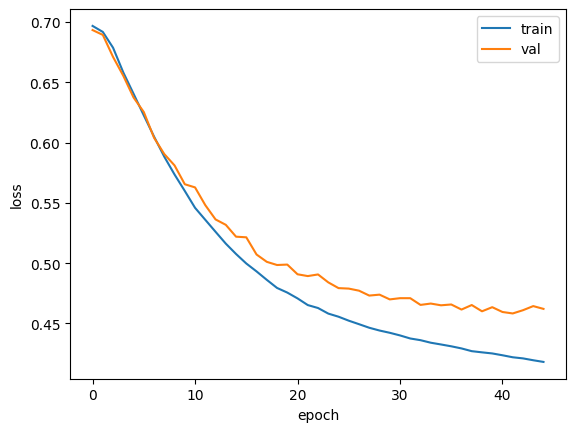

In [ ]:
# 손실 그래프 그리기

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# 원-핫 인코딩을 사용하면 데이터가 매우 커짐
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


## 단어 임베딩(word embedding)
- 각 단어를 고정된 크기의 실수 벡터로 변환하는 텍스트 처리 방법
- 처음에는 모든 벡터가 랜덤으로 초기화되지만 훈련을 통해 좋은 단어 임베딩을 학습
- keras.layers 패키지 하위에 Embedding 클래스가 포함되어 있음
- 원-핫 인코딩과 달리 훨씬 의미 있는 값으로 구성되어 있고 샘플의 크기가 작아 자연어 처리에서 자주 활용

In [ ]:
# Embedding 클래스를 추가한 두 번째 순환 신경망 생성

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))  # 순서대로 어휘 사전의 크기, 임베딩 벡터의 크기, 입력 시퀀스의 길이
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8209 (32.07 KB)
Trainable params: 8209 (32.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- Embedding 클래스는 500개의 토큰을 크기가 16인 벡터로 변환해 500 x 16개의 모델 파라미터를 가짐
- 순환층은 총 200개의 파라미터를 가짐
  - 16개의 벡터가 8개의 뉴런과 곱해질 때 필요한 가중치 8 x 16 = 128개
  - 은닉 상태에 곱해지는 가중치 8 x 8 = 64개
  - 절편 8개

In [ ]:
# 새로운 순환 신경망 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 21ms/step - loss: 0.6624 - accuracy: 0.6073 - val_loss: 0.6347 - val_accuracy: 0.6614
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6105 - accuracy: 0.7024 - val_loss: 0.5986 - val_accuracy: 0.7228
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5846 - accuracy: 0.7371 - val_loss: 0.5811 - val_accuracy: 0.7350
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5653 - accuracy: 0.7555 - val_loss: 0.5637 - val_accuracy: 0.7574
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5492 - accuracy: 0.7660 - val_loss: 0.5501 - val_accuracy: 0.7682
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5356 - accuracy: 0.7747 - val_loss: 0.5418 - val_accuracy: 0.7686
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5225 - accuracy: 0.7822 - val_loss: 0.5281 - val_accuracy:

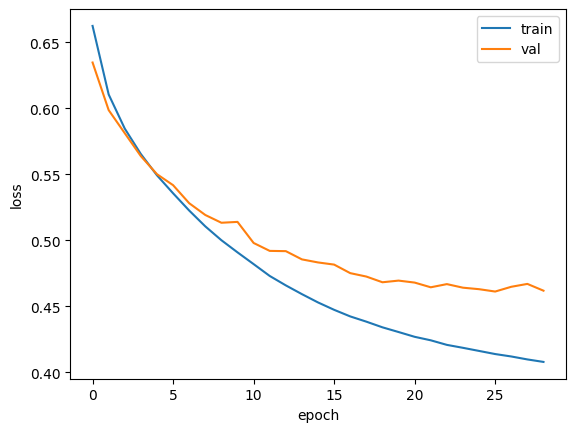

In [ ]:
# 손실 그래프 그리기

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 원-핫 인코딩 방식과 비슷한 성능을 보이지만 가중치 개수가 적고 훈련 세트의 크기도 감소함